<a href="https://colab.research.google.com/github/xxxcrttt/CASA0018----DLSN/blob/main/TinyML/Chap4_Test_and_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. What We’re Building
#### Part 1. 
目标是训练一个可以给定输入值 x 预测其正弦值 y 的模型。    
#### Part 2. 
在硬件设备上运行这个模型 -- 控制灯光进行视觉表演   
三种设备：SparkFun Edge, Arduino Nano 33 BLE Sense, ST Microelectronics STM32F736G Discovery. 



# 2. Machine Learning Toolchain

#### 1. Python and Jupyter Notebook    
#### 2. Google Colaboratory    
#### 3. TensorFlow and Keras    
**TensorFlow** -- 用于构建，训练，评估和部署ML model 的工具；  
高级API **Keras** -- 创建和训练Deep Learning Network；   
**TensorFlow Lite** -- 部署到移动端和嵌入式设备的工具

# Building Our Model

### Importing Dependencies
导入依赖项    
* ```import``` 语句用于加载库
* ```pip``` 用于下载
* 导入```TensorFlow, Numpy, Matplotlib, math ```


In [ ]:
# TensorFlow is an open source ML library 
!pip install TensorFlow==2.0

     |████████████████████████████████| 86.3 MB 42 kB/s 
     |████████████████████████████████| 3.8 MB 49.3 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 449 kB 51.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e24f5631325df04009d347de64010088bdb523710306858d42aab627198deb81
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [ ]:
import tensorflow as tf
import numpy as np # math lib
import matplotlib.pyplot as plt # graph lib
import math

### Generating Data
DL 通过学习数据内在的模式来构建模型 -- 产生模型，该模型获取一个 x 值，并预测其 sine 值 y   

计划是生成1000个代表正弦波上随机点的值；  

波的每一个完整循环被称为**周期(period)**, 正弦波的周期为 2pie   
代码将随机产生 0~2pie 的 x，并计算它们的 y 值 

**np.random.uniform()** 生成 x 值，返回指定范围内的随机数组    

**shuffle** 对数据进行随机排列 -- 重要！！以为DL中使用的训练过程依赖于以整整的随机顺序输入数据；若数据是有序的，可能不会那么准确   

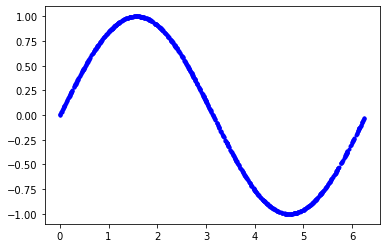

In [ ]:
# Generate 1000 sample datapoint
Samples = 1000

# set a "seed" value, get the same random numbers each time, can use any value 
Seed = 1335 

np.random.seed(Seed)
tf.random.set_seed(Seed)

# Generate a uniformally distributed set of random numbers in the range(0, 2pie)
# which covers a complete sine wave oscillation 
x_values = np.random.uniform(low=0, high=2*math.pi, size= Samples)

# Shuffle the values to guarantee they are not in order 
np.random.shuffle(x_values)

# Calculate the cprresponding sine waves 
y_values = np.sin(x_values)

# plot the data
plt.plot(x_values, y_values, 'b.')
plt.show()

#### 加入噪声 noise
从噪声中过滤出模式

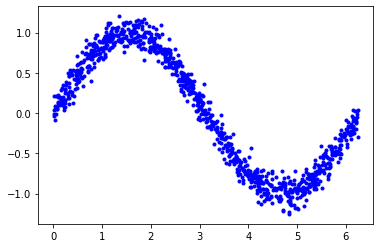

In [ ]:
# Add a small random number to each y value -- noise
y_values += 0.1 * np.random.randn(*y_values.shape)

# plot
plt.plot(x_values, y_values,'b.')
plt.show()

### Splitting the Data 拆分数据
为了评估训练模型的准确率，将预测的数据与实际的数据进行比较，检查匹配程度   

60% -- training + 20% -- validation + 20% -- testing  

**np.split()** 输入一个数据数组 + 一个索引数组，根据提供的索引将数据分为若干部分

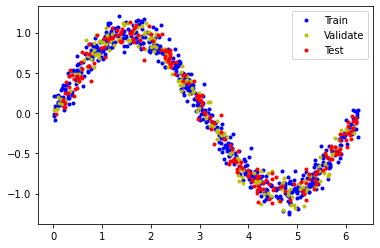

In [ ]:
# 60% -- training + 20% -- validation + 20% -- testing   
train_split = int(0.6*Samples)
test_split = int(0.2*Samples + train_split)

# split the data into 3 parts. 
x_train, x_vali, x_test = np.split(x_values, [train_split, test_split])
y_train, y_vali, y_test = np.split(y_values, [train_split, test_split])

# double check that the splits add up correctly 
assert (x_train.size + x_vali.size + x_test.size) == Samples

# plot 
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_vali, y_vali, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

### Defining a Basic Model 定义基本模型
**回归(regression)**:    
接受一个输入值并预测一个数字输出值 -- 训练任何需要输出数字的任务 

**keras.Sequential()**:    
序列模型 -- 表示模型中的每一层神经都堆叠在下一层之上   

**第一层**：
```
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))
```
只有一个输入(x) & 16 neurons, 这是一个**Dense(密集) / 全连接层(fully connected layer)**层   

在推断过程中的输入将被输入这一层的*每一个*神经元中  

然后每个神经元将在一定程度上被**激活(activate)**, 每个神经元的激活量取决于它在训练过程中获得的**权重(weight) & 偏差(bias)**, 以及它的**激活函数(activation function)** -- 用于模拟神经元 

神经元的激活方式将以数字的形式输出，激活程度通过简单公式计算，由TensorFlow处理 -- 输入 X 权重 + 偏差 
```
activation = activation_function((input * weight) + bias)
```
线性整流单元 -- Rectified Linear Unit, ReLU 
```
activation = 'relu'
```
ReLu 返回 input & 0 中较大的值 -- 若 input 为负，返回 0；否则返回 input 
```
ReLU 函数:
def relu(input):
    return max(0.0, input)
```

若没有激活函数，神经元的输出将始终是其输入的线性函数，意味着网络只能对线性关系建模，x 和 y 的比值在一定范围内相同  

非线性关系允许多层神经元相互作用

来自第一层的激活函数将作为第二层的输入, 由单个神经元组成，接受16个输入(上层每个神经元的输出)    
-- 目的是奖上一层的所有激活函数程度值合并为一个输出值 
```
model_1.add(layers.Dense(1))
```
输出通过以下公式计算:
```
output = sum((inputs * weights) + bias)
```

网络的权重和偏差是训练期间学习得到的，compile() 步骤配置了训练过程中使用的重要参数和训练模型:
```
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
```
**optimizer()优化器** 指定在训练期间用于调整网络以对其输入进行建模的算法 -- 有很多选择    
**loss()损失函数** 指定了训练期间用来计算网络预测值与真实值之间的距离的方法 -- loss function   
* mse  = mean squared error (均方误差)    

**metrics(度量指标)** 指定用于评测模型表现的函数   
* mae  = mean absolute error (平均绝对误差)

**summary()** 显示了网络层，输出形状和参数数目

网络大小 -- 占用内存 -- 主要取决于参数 == 权重 + 偏差 

对于简单模型，可以通过计算模型中神经元之间的连接数目来得到权重的数目 






In [ ]:
from tensorflow.keras import layers
# 这里不能写 tf.keras -- cannot use the alias to import other modules
# 序列模型：
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 neurons 
# neurons decide whether to activate based on the 'relu' activation function.
# 第一层定义：
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# Final layer is a single neuron -- output is a single value 
# add 16 neurons together 
# 第二层: 
model_1.add(layers.Dense(1))

# Compile the model using a standard optimiser and loss function for regression
# 配置重要参数和训练模型 
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# print a summary of the model's architecture
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


# Training Model 训练模型

**fit()** -- 训练模型，传入所有数据和重要参数

调用的返回值赋给了名为 history_1 的变量，它包含大量有关于训练运行情况的信息 

参数：

x_train & y_train: 

训练数据 x 和 y 值，将会保留部分数据用于验证和测试，因此只使用训练集来训练网络

epochs(次数): 

指定在整个训练期间通过网络运行的轮次总数；epoches越大训练次数越多 -- 并不是越多越好，过拟合问题

batch_size: 

指定在测量网络的准确率并更新其权重和偏差之前，需要向网络输入多少训练数据 --    
设定为 1 时意味着将在单个数据点上运行   
研究表明: 使用大批次进行训练的模型推广到新数据的能力较低，它们更容易出现过拟合的问题 -- 折中方案是使用居中的批次大小

validation_data: 

指定验证数据集


In [ ]:
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16, 
                        validation_data = (x_vali, y_vali))

Train on 600 samples, validate on 200 samples
Epoch 1/1000
600/600 [==============================] - 1s 2ms/sample - loss: 0.3970 - mae: 0.5458 - val_loss: 0.4112 - val_mae: 0.5568
Epoch 2/1000
600/600 [==============================] - 0s 157us/sample - loss: 0.3449 - mae: 0.5075 - val_loss: 0.3606 - val_mae: 0.5175
Epoch 3/1000
600/600 [==============================] - 0s 177us/sample - loss: 0.3053 - mae: 0.4761 - val_loss: 0.3181 - val_mae: 0.4892
Epoch 4/1000
600/600 [==============================] - 0s 214us/sample - loss: 0.2707 - mae: 0.4504 - val_loss: 0.2783 - val_mae: 0.4618
Epoch 5/1000
600/600 [==============================] - 0s 152us/sample - loss: 0.2420 - mae: 0.4280 - val_loss: 0.2494 - val_mae: 0.4363
Epoch 6/1000
600/600 [==============================] - 0s 166us/sample - loss: 0.2177 - mae: 0.4053 - val_loss: 0.2232 - val_mae: 0.4160
Epoch 7/1000
600/600 [==============================] - 0s 156us/sample - loss: 0.1987 - mae: 0.3886 - val_loss: 0.1985 - val_ma

### Training Metrics 训练度量指标

显示网络在训练过程中是如何从随机初始状态开始一步步改进的
```
epoch 1/1000
600/600 [==============================] - 1s 2ms/sample - loss: 0.3970 - mae: 0.5458 - val_loss: 0.4112 - val_mae: 0.5568

epoch 1000/1000
600/600 [==============================] - 0s 202us/sample - loss: 0.1310 - mae: 0.2777 - val_loss: 0.1157 - val_mae: 0.2657
```
**loss**

损失函数的输出，使用均方误差，值都是正数 -- 一般来说损失值越小越好

**mae** 

训练数据的平均绝对误差，显示了网络预测值和训练数据中 y 值之间的平均差 

**val_loss** 

损失函数在验证数据上的输出，最后一轮中训练损失值(约0.15)略低于验证损失值(约0.17)，表明网络可能出现了过拟合，因为他在处理从未见过的数据时表现力较差

**val_mae** 

验证数据的平均绝对误差 


### Graphing the History 绘制历史数据
history_1 对象包含了名为 history_1.history 的属性，是一个字典，用于记录训练期间和验证期间的度量指标

如图，在前50个轮次，损失迅速减少，然后趋近于平缓 ==》 该模型正在改进并产生更准确的预测

目标： 当模型不再改进 or 训练损失小于实验损失时停止训练 ==》 意味着模型已经学会了很好的预测训练模型

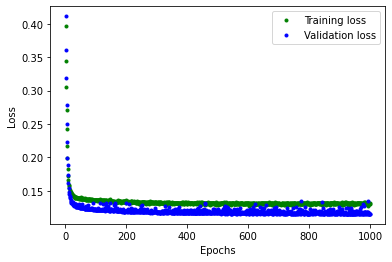

In [ ]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 放大 

损失在前几个轮次急速下降，使得图片很难读懂，此时跳过前 100 个轮次

放大了后面的轮次可以看到损失仍在持续减少，until about 600 epochs. 而且验证损失值始终比训练损失高

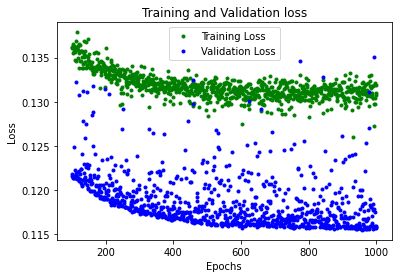

In [ ]:
# Exclude the first 100 epochs 
Skip = 100

plt.plot(epochs[Skip:], loss[Skip:],'g.', label='Training Loss')
plt.plot(epochs[Skip:], val_loss[Skip:],'b.', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### MAE 平均绝对误差

平均而言，训练数据的误差低于验证数据的误差 ==》 网络可能存在过拟合

且MAE误差非常高(0.31)，意味着模型的某些预测误差至少为 0.31



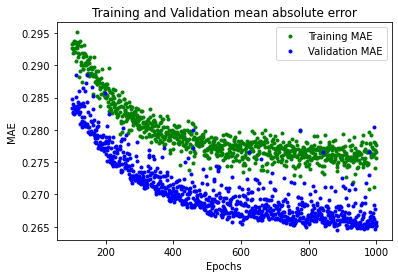

In [ ]:
# plot mean absolute error
# another way of measuring the amount of error in the prediction 
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[Skip:], mae[Skip:], 'g.', label='Training MAE')
plt.plot(epochs[Skip:], val_mae[Skip:], 'b.', label='Validation MAE')
plt.title('Training and Validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### 网络期望值
网络对于训练数据的预测值和期望值 

通过调用```model_1.predict(x_train)```可以对训练数据中所有的 x 值进行推断，返回一个预测数组

清楚表明：网络已经学会以非常有限的方式接近正弦函数，这些预测是高度线性的，并且只能非常粗略的拟合数据

这种僵化的拟合表明：模型*没有* 足够的能力来学习 sine 的函数的全部复杂性，因此只能以非常简单的方式进行近似

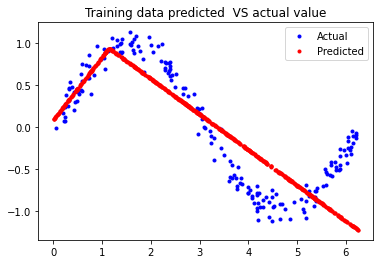

In [ ]:
# use the model to make predictions from validation data
predictions = model_1.predict(x_train)

# plot the predictions along with the test data 
plt.clf()
plt.title('Training data predicted  VS actual value')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

### Improving Model  改进模型

使得网络更大的一个简单方法是添加另一层神经元，神经元的每一层都代表对输入的一次转换，并希望可以使得转换后的结果更接近预期的输出

网络具有的神经元层数越多，转换就越复杂

新模型有两层包含 16 个神经元的额层，具有 ```288 weights + (16 + 16 + 1) = 33 bias = 321 para```


In [41]:
# Add 2nd layer model
model_2 = tf.keras.Sequential()

model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# The new 2nd layer may help the network learn more complex representations
model_2.add(layers.Dense(16, activation='relu'))

# Final layer is a single neuron, 
model_2.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression 
model_2.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])

# show a summary of the model
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


改进： 

验证损失： 0.17 --> 0.01

验证平均误差: 0.32 --> 0.08

```
Epoch 1/600
600/600 [==============================] - 1s 1ms/sample - loss: 2.2686 - mae: 1.2070 - val_loss: 1.1358 - val_mae: 0.9161
Epoch 600/600
600/600 [==============================] - 0s 194us/sample - loss: 0.0113 - mae: 0.0841 - val_loss: 0.0104 - val_mae: 0.0830
```

In [42]:
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
                         validation_data=(x_vali, y_vali))

Train on 600 samples, validate on 200 samples
Epoch 1/600
600/600 [==============================] - 1s 1ms/sample - loss: 2.2686 - mae: 1.2070 - val_loss: 1.1358 - val_mae: 0.9161
Epoch 2/600
600/600 [==============================] - 0s 168us/sample - loss: 0.7579 - mae: 0.7709 - val_loss: 0.5444 - val_mae: 0.6608
Epoch 3/600
600/600 [==============================] - 0s 182us/sample - loss: 0.4378 - mae: 0.5751 - val_loss: 0.4362 - val_mae: 0.5668
Epoch 4/600
600/600 [==============================] - 0s 200us/sample - loss: 0.3486 - mae: 0.5074 - val_loss: 0.3452 - val_mae: 0.5092
Epoch 5/600
600/600 [==============================] - 0s 185us/sample - loss: 0.2814 - mae: 0.4577 - val_loss: 0.2776 - val_mae: 0.4566
Epoch 6/600
600/600 [==============================] - 0s 160us/sample - loss: 0.2259 - mae: 0.4112 - val_loss: 0.2202 - val_mae: 0.4112
Epoch 7/600
600/600 [==============================] - 0s 171us/sample - loss: 0.1841 - mae: 0.3731 - val_loss: 0.1760 - val_mae: 0.36

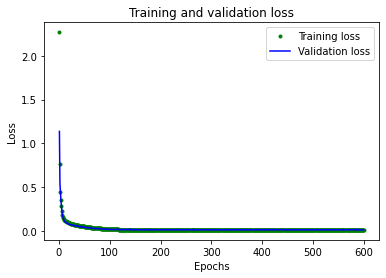

In [43]:
# Draw a graph of the loss = the distance between 
# the predicted and actual values during training and validation 
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

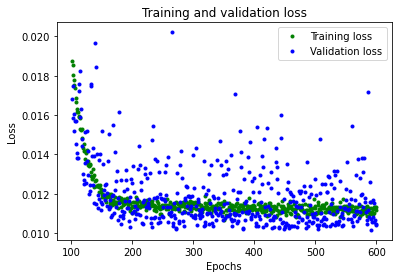

In [45]:
# Exclude the first 100 epochs 
Skip = 100

plt.clf()

plt.plot(epochs[Skip:], loss[Skip:], 'g.', label='Training loss')
plt.plot(epochs[Skip:], val_loss[Skip:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

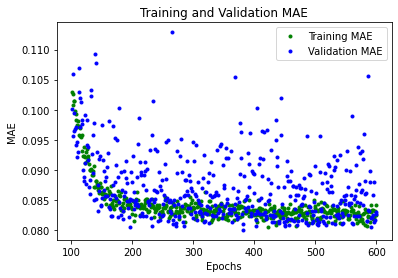

In [46]:
# mean absolute value 
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[Skip:], mae[Skip:], 'g.',label='Training MAE')
plt.plot(epochs[Skip:], val_mae[Skip:],'b.',label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

很好的结果！！
* 总体来说，验证集上的度量数据要好于训练集 ==》 网络没有出现过拟合
* 整体损失和平均绝对误差比之前的网络要好

验证集的度量数据是每个轮次结束时计算的，而训练数据的度量数据是在训练期间计算的 

==》 意味着验证是在训练了较长时间的模型上进行的

### Testing 


200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

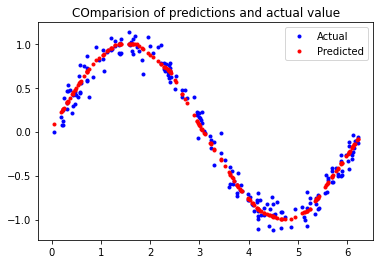

In [47]:
# calculate and print the loss on test dataset
loss = model_2.evaluate(x_test, y_test)

# Make predictions based on test dataset
predictions = model_2.predict(x_test)

# Graph the predictions against the actual value
plt.clf()
plt.title('COmparision of predictions and actual value')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

**evaluate()** 

测试数据调用模型，会计算并打印损失值和平均绝对误差，模型的预测值和实际值的偏离程度
 ```
 - 0s 58us/sample - loss: 0.0102 - mae: 0.0856
 ```
输出表明：评估了200个数据点 -- 及整个测试集，花费了 71 ms，损失值为 0.0102，接近验证损失 0.0104；平均绝对误差 0.0856，接近验证集中的0.0806 



In [48]:
loss = model_2.evaluate(x_test, y_test)

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

以上是模型学习到的随机分布的变化，是一个**轻微过拟合**的状态：模型学习的并不是平滑的 sine 函数，而是复制了数据的精确情况 

